In [6]:
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

import numpy as np
import pandas as pd
from model.Crossformer import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:

#DATASET 
ROOT_PATH = "data/DatasetClusters/fishes/fish02/"
DATA_PATH = "fish_02_pairs.csv"
#Device
DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [8]:

## Sim input 
stride = 50
in_len = 1031
out_len = 1031

index = ((1031 - in_len) // stride) + 1
print(index)
j = 0
for i in range(0,index,1):
    s_begin = i * stride
    s_end = s_begin + in_len
    r_begin = s_end
    r_end = r_begin + out_len
    #r_begin = s_begin
    #r_end = r_begin + self.out_len
    r_begin = s_begin
    r_end = r_begin + out_len


    j+=1
    print(s_begin,s_end)
    print(j)

1
0 1031
1


In [9]:
def generate_patch_list(n):
    # Create the negative patches
    neg_patches = [f"-{i}-patch" for i in range(n, 0, -1)]
    # The 'synch' entry
    synch = ['synch']
    # Create the positive patches
    pos_patches = [f"{i}-patch" for i in range(1, n+1)]
    # Combine all parts into the final list
    return neg_patches + synch + pos_patches

final_list_order = generate_patch_list(4)

final_list_order
#final_list_order = ['-4-patch','-3-patch', '-2-patch', '-1-patch', 'synch', '1-patch', '2-patch', '3-patch','4-patch']


['-4-patch',
 '-3-patch',
 '-2-patch',
 '-1-patch',
 'synch',
 '1-patch',
 '2-patch',
 '3-patch',
 '4-patch']

## Load model

In [10]:

#model = torch.load("hpc_model/model_1_head_25_strid_win_1_layer_1_recon.pth", map_location=torch.device('cpu'))
model = torch.load("hpc_model/REC_FULL.pth", map_location=torch.device('cpu'))
#pair = 6
#model = torch.load(f"hpc_model/pairswise/model_pair_{pair}.pth", map_location=torch.device('cpu'))

### Load attentions

In [11]:
tsa_layer = model.encoder.encode_blocks[0].encode_layers[0]
tsa_layer_weights = tsa_layer.get_attn()
decoder = model.decoder.decode_layers[0]
dec_attn=decoder.get_attn()
len(tsa_layer_weights)

384

## Group by pair

In [12]:
def organize_by_pair_index(weights):
    organized = {}  # Dictionary to store the lists organized by 'pair_index'
    
    for item in weights:
        index = item['pair_index']  # Get the 'pair_index' from the dictionary
        
        # Check if the 'pair_index' is already a key in the organized dictionary
        if index not in organized:
            organized[index] = []  # If not, create a new list for this 'pair_index'
        
        # Append the current item to the list corresponding to its 'pair_index'
        organized[index].append(item)
    
    return organized



In [13]:
d = organize_by_pair_index(tsa_layer_weights)
d[0]

[{'pair_index': 0,
  'att-A-B': tensor([[[[6.6835e-02, 2.0231e-01, 3.6320e-01, 3.4660e-01, 2.1058e-02],
            [9.3314e-02, 2.4441e-01, 3.6198e-01, 2.6745e-01, 3.2848e-02],
            [2.0485e-01, 1.2774e-01, 1.4325e-01, 1.0350e-01, 4.2066e-01],
            [5.7455e-02, 3.0871e-01, 4.5497e-01, 1.4368e-01, 3.5176e-02],
            [5.2965e-02, 2.0117e-01, 3.8695e-01, 3.4050e-01, 1.8417e-02]]],
  
  
          [[[1.6162e-01, 2.1170e-01, 2.4613e-01, 1.9838e-01, 1.8216e-01],
            [1.8583e-01, 1.2323e-01, 9.0703e-02, 3.8549e-01, 2.1474e-01],
            [7.0672e-02, 6.5883e-01, 2.5465e-01, 6.4063e-03, 9.4418e-03],
            [1.8356e-01, 2.5260e-01, 3.2054e-01, 5.7874e-02, 1.8543e-01],
            [4.4378e-02, 2.2505e-02, 4.7210e-02, 6.0686e-01, 2.7905e-01]]],
  
  
          [[[1.7457e-01, 2.1138e-01, 1.7812e-01, 2.5702e-01, 1.7890e-01],
            [2.4684e-01, 1.1599e-01, 5.6409e-02, 9.2467e-03, 5.7151e-01],
            [1.2450e-01, 1.5387e-01, 1.4772e-01, 5.4756e-02, 5.191

In [14]:
def flatten_pair(first_pair): 
    first_a_b = []
    first_b_a = []    
    for batch_sets in first_pair:
        for ele in batch_sets['att-A-B']:
            first_a_b.append(ele)
        for ele in batch_sets['att-B-A']:
            first_b_a.append(ele)
        
        
    return first_a_b,first_b_a


In [15]:
first_a_b,first_b_a = flatten_pair(d[0])
first_a_b[0]

tensor([[[0.0668, 0.2023, 0.3632, 0.3466, 0.0211],
         [0.0933, 0.2444, 0.3620, 0.2674, 0.0328],
         [0.2049, 0.1277, 0.1432, 0.1035, 0.4207],
         [0.0575, 0.3087, 0.4550, 0.1437, 0.0352],
         [0.0530, 0.2012, 0.3869, 0.3405, 0.0184]]])

## Organize in dictionary

In [16]:
import itertools
# Initialize an empty dictionary
def create_seg_dic():
    stride = 50 
    in_len = 100
    out_len = 100

    index = ((1031 - in_len -out_len) // stride) + 1
    patch_size = 20
    segmented_bins_dict = {}

    # Iterate over the 1000 points, 100 at a time with a stride of 25
    for segment_start in range(0, 1031, stride):
        segment_end = segment_start + 99
        segment_key = f"{segment_start}-{segment_end}"  # Key for the segment
        bins_dict = {}  # Temporary dictionary to hold bins for this segment
        
        # Create bins within the current segment
        for bin_start in range(segment_start, segment_start+100, patch_size):
            bin_end = bin_start + patch_size-1
            bin_key = f"{bin_start}-{bin_end}"  # Create a string key for the bin
            bins_dict[bin_key] = []  # Initialize an empty list as the value for each bin
        
        # Add the bins dictionary to the segmented dictionary
        segmented_bins_dict[segment_key] = bins_dict
        
    
    seg_dic = dict(itertools.islice(segmented_bins_dict.items(), index))
    
    return seg_dic


In [17]:
# Based on number of pathes and input length
def reorder_segment(dic):  
    # Transforming the structure with conditional inner keys
    for segment_key, patches in dic.items():
        patch_keys = list(patches.keys())  # List of patch keys for indexing
        num_patches = len(patch_keys)  # Total number of patches
        for i, patch_key in enumerate(patch_keys):
            # Initialize the new dictionary for each patch
            new_dict = {}
            # Determine which keys to include based on patch position
            key_offsets = range(max(-9, -i), min(10, num_patches - i))  # Adjust the range based on patch position
            
            for j in key_offsets:  # Only include keys within the valid range
                if j == 0:
                    new_key = 'synch'
                else:
                    new_key = f'{j}-patch'
                new_dict[new_key] = None  # Assign None to each valid key
                
            # Assign the new dictionary to the current patch
            dic[segment_key][patch_key] = new_dict

    return dic


In [18]:
def fill_dicts(first_a_b,first_b_a,first_a_b_dic,first_b_a_dic,THRESHOLD):
    j = 0
    i = 0
    k = 0
    
    for segment_key, patches in first_a_b_dic.items():
        j=0
        for patch_key, inner_keys in patches.items():
            k=0
            for key in inner_keys.keys():
                first_a_b_dic[segment_key][patch_key][key] = first_a_b[i][j][k] if first_a_b[i][j][k] > THRESHOLD else "ignore"
                k += 1
            j+=1
        i+=1
    
    j = 0
    i = 0
    k = 0
    for segment_key, patches in first_b_a_dic.items():
        j=0
        for patch_key, inner_keys in patches.items():
            k=0
            for key in inner_keys.keys():
                first_b_a_dic[segment_key][patch_key][key] = first_b_a[i][j][k] if first_b_a[i][j][k] > THRESHOLD else "ignore"
                k += 1
            j+=1
        i+=1
    
    
    return first_a_b_dic,first_b_a_dic
    


## Find expected probabilities of attentions

In [19]:
def sum_up(data,name):
    sums_counts = {}
    # Go through the dictionary and sum values and count occurrences for each key
    for outer_key in data:
        for inner_key in data[outer_key]:
            for key, value in data[outer_key][inner_key].items():
                if value == "ignore":
                    continue
                if key not in sums_counts:
                    sums_counts[key] = {'sum': 0, 'count': 0}
                sums_counts[key]['sum'] += value
                sums_counts[key]['count'] += 1
               
    # Calculate averages
    averages = {}
    for key in sums_counts:
        averages[key] = sums_counts[key]['sum'] / sums_counts[key]['count']
        
        
    # Prepare the final list in the specified order
    final_list_order = generate_patch_list(4)
    final_list = [averages.get(key, 0) for key in final_list_order]

    plt.figure(figsize=(20, 8))
    plt.stem(final_list_order, final_list,basefmt="")
    plt.title(name)
    plt.xlabel('Key')
    plt.ylabel('Average Value')
    plt.grid()
    #plt.savefig(f"attn_dfs_test/images/expAttn/{name}.png") 
    plt.show()
    
    return sums_counts,final_list, averages   

## Create heatmap plots of patches attentions

In [20]:
def extract_patches(dic): 
    sub_keys = []
    for outer_key in dic:
        for inner_key in dic[outer_key]:
            sub_keys.append(inner_key)
            
    return sub_keys

In [21]:
import re

def parse_interval(interval):
    # Extract both the start and end numbers from the interval string
    match = re.match(r"(\d+)-(\d+)", interval)
    if match:
        start = int(match.group(1))
        end = int(match.group(2))
        return (start, end)
    return (0, 0)  # Default case if the regex does not find a match



In [22]:
def find_duplicates(input_list):
    # Dictionary to count each element's occurrence
    count_dict = {}
    # List to hold the duplicate elements
    duplicates = []

    # Count each element's occurrences
    for item in input_list:
        if item in count_dict:
            count_dict[item] += 1
        else:
            count_dict[item] = 1

    # Collect elements that occur more than once
    for item, count in count_dict.items():
        if count > 1:
            duplicates.append(item)

    return duplicates


In [23]:

def create_heatmap(sorted_intervals,dic):
    heat_map = {}
    for item in sorted_intervals:
        for outer_key in dic:
            for inner_key in dic[outer_key]:
                if(inner_key==item):
                    heat_map[inner_key]=dic[outer_key][inner_key]
                    
    return heat_map
        

In [24]:

def organize_heat_map(heat_map,final_list_order):
    for segs in heat_map:
        for ele in final_list_order:
            if ele not in heat_map[segs]:
                heat_map[segs][ele] = -np.inf

    return heat_map


In [25]:
def create_heatmap_plot(df,name):
    # create matrix
    size = 100000
    # Create a colormap that uses grey for NaN
    cmap = sns.color_palette("YlOrBr", as_cmap=True)
    cmap.set_bad('grey')  # Set the color for NaN values
    # Create figure and plot heatmap
    plt.figure(figsize=(8, 20))
    sns.heatmap(df, cmap=cmap, vmin=0, vmax=1)
    plt.title(name)
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    #plt.savefig(f"attn_dfs_test/images/heatmaps/{name}.png") 
    plt.show()
    

# Create top methods for all the over

In [26]:
def create_attn_dicts(par_index,Num_head,THRESHOLD):
    attens_by_pairs = organize_by_pair_index(tsa_layer_weights)
    choosen_pair = attens_by_pairs[par_index] 
    choosen_pair_a_b,choosen_pair_b_a = flatten_pair(first_pair=choosen_pair)
    
  
    # extract the data in numpy
    choosen_pair_a_b = np.array(choosen_pair_a_b)
    choosen_pair_b_a = np.array(choosen_pair_b_a)
    
    if Num_head ==1:
        choosen_pair_a_b = choosen_pair_a_b.squeeze(axis=1)
        choosen_pair_b_a = choosen_pair_b_a.squeeze(axis=1)
        
    #Create dicts for ordering patches   
    a_b_dic = create_seg_dic()
    b_a_dic = create_seg_dic()
    
    a_b_dic = reorder_segment(a_b_dic)
    b_a_dic = reorder_segment(b_a_dic)
    # fill the dicts
    a_b_dic_ordered,b_a_dic_ordered = fill_dicts(first_a_b=choosen_pair_a_b,
                                         first_b_a=choosen_pair_b_a,
                                         first_a_b_dic=a_b_dic,
                                         first_b_a_dic=b_a_dic,
                                         THRESHOLD = THRESHOLD
                                         
                                         )
    
    return a_b_dic_ordered,b_a_dic_ordered

In [27]:
def calc_expected_attn(a_b_dic_ordered,b_a_dic_ordered,name_a,name_b):
    sums_counts_a,final_list_a, averages_a  = sum_up(a_b_dic_ordered,name_a)
    sums_counts_b,final_list_b, averages_b  = sum_up(b_a_dic_ordered,name_b)
    
    return sums_counts_a,final_list_a, averages_a,sums_counts_b,final_list_b, averages_b 
    

In [28]:
def heatmap(a_b_dic_ordered,b_a_dic_ordered,final_list_order,name1,name2):
    sub_keys_a = extract_patches(a_b_dic_ordered)
    sub_keys_b = extract_patches(b_a_dic_ordered)
    sorted_keys_a = sorted(sub_keys_a, key=parse_interval)
    sorted_keys_b = sorted(sub_keys_b, key=parse_interval)
    
    print(find_duplicates(sorted_keys_a))    
    heatmap_a = create_heatmap(sorted_keys_a,a_b_dic_ordered)
    heatmap_b = create_heatmap(sorted_keys_b,b_a_dic_ordered)
    
    heatmap_a = organize_heat_map(heatmap_a,final_list_order)
    heatmap_b = organize_heat_map(heatmap_b,final_list_order)
    
    df_a_b = pd.DataFrame(heatmap_a).T
    df_a = df_a_b[final_list_order]

    df_b_a= pd.DataFrame(heatmap_b).T
    df_b = df_b_a[final_list_order]



    df_a = df_a.replace(-np.inf, np.nan).replace("ignore", 0).astype(float)
    df_b = df_b.replace(-np.inf, np.nan).replace("ignore", 0).astype(float) 
    create_heatmap_plot(df_a,name1)
    
    create_heatmap_plot(df_b,name2)
    
    return df_a, df_b
    
    

In [39]:
a_b_dic_ordered,b_a_dic_ordered = create_attn_dicts(par_index=2,Num_head=1,THRESHOLD=0.3)

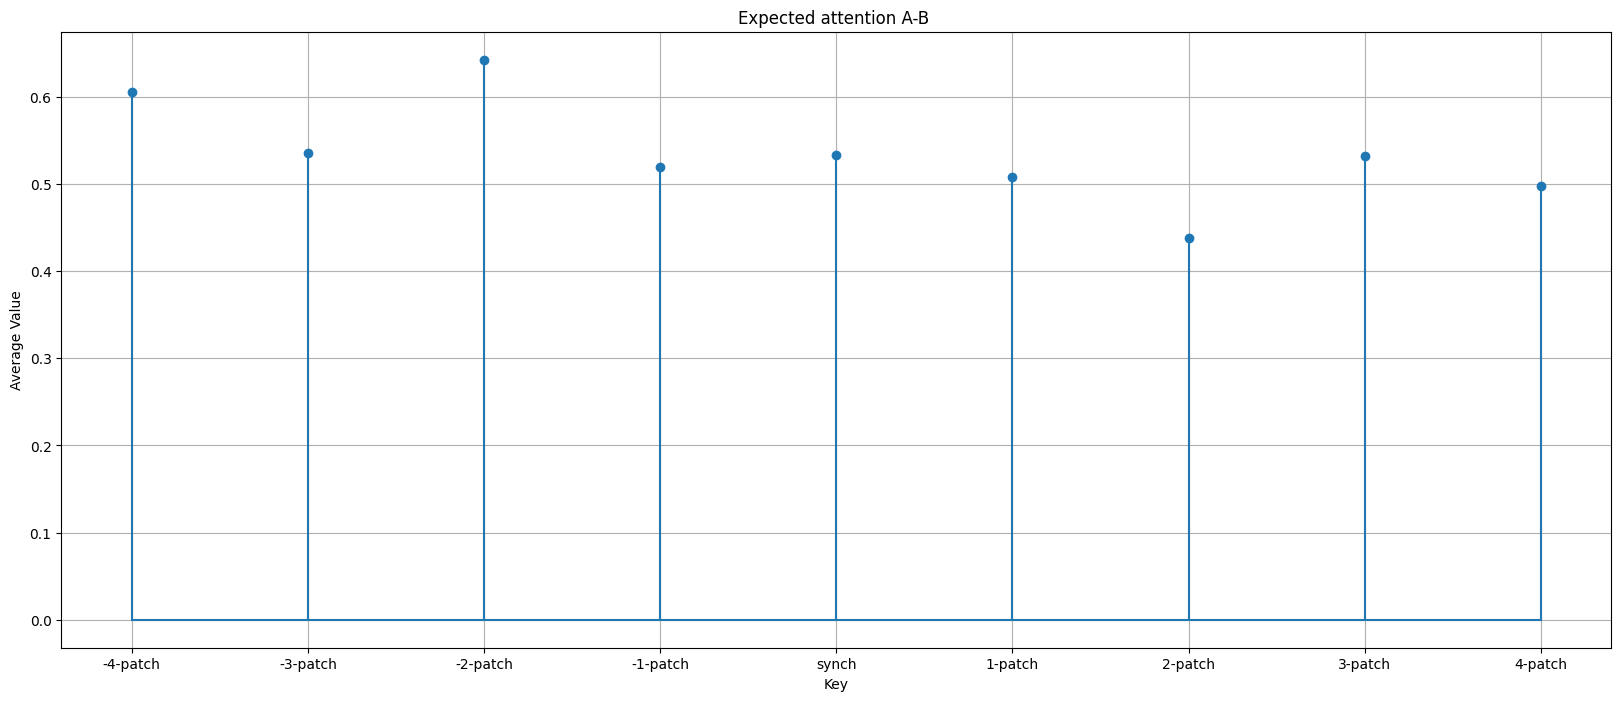

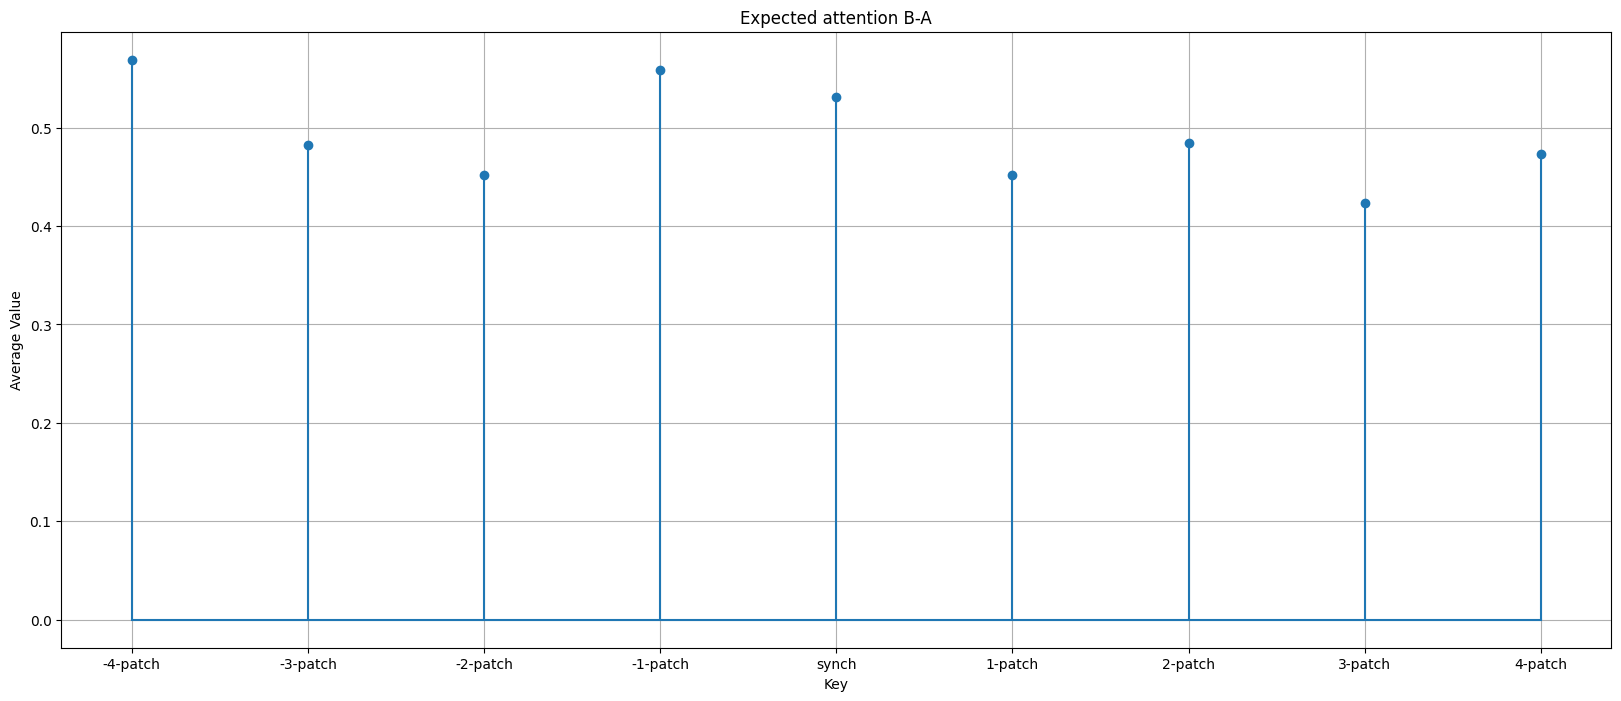

In [40]:
sums_counts_a,final_list_a, averages_a,sums_counts_b,final_list_b, averages_b  = calc_expected_attn(a_b_dic_ordered,b_a_dic_ordered,f"Expected attention A-B ","Expected attention B-A")

[]


/tmp/ipykernel_107278/207739452.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_a = df_a.replace(-np.inf, np.nan).replace("ignore", 0).astype(float)
/tmp/ipykernel_107278/207739452.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_b = df_b.replace(-np.inf, np.nan).replace("ignore", 0).astype(float)


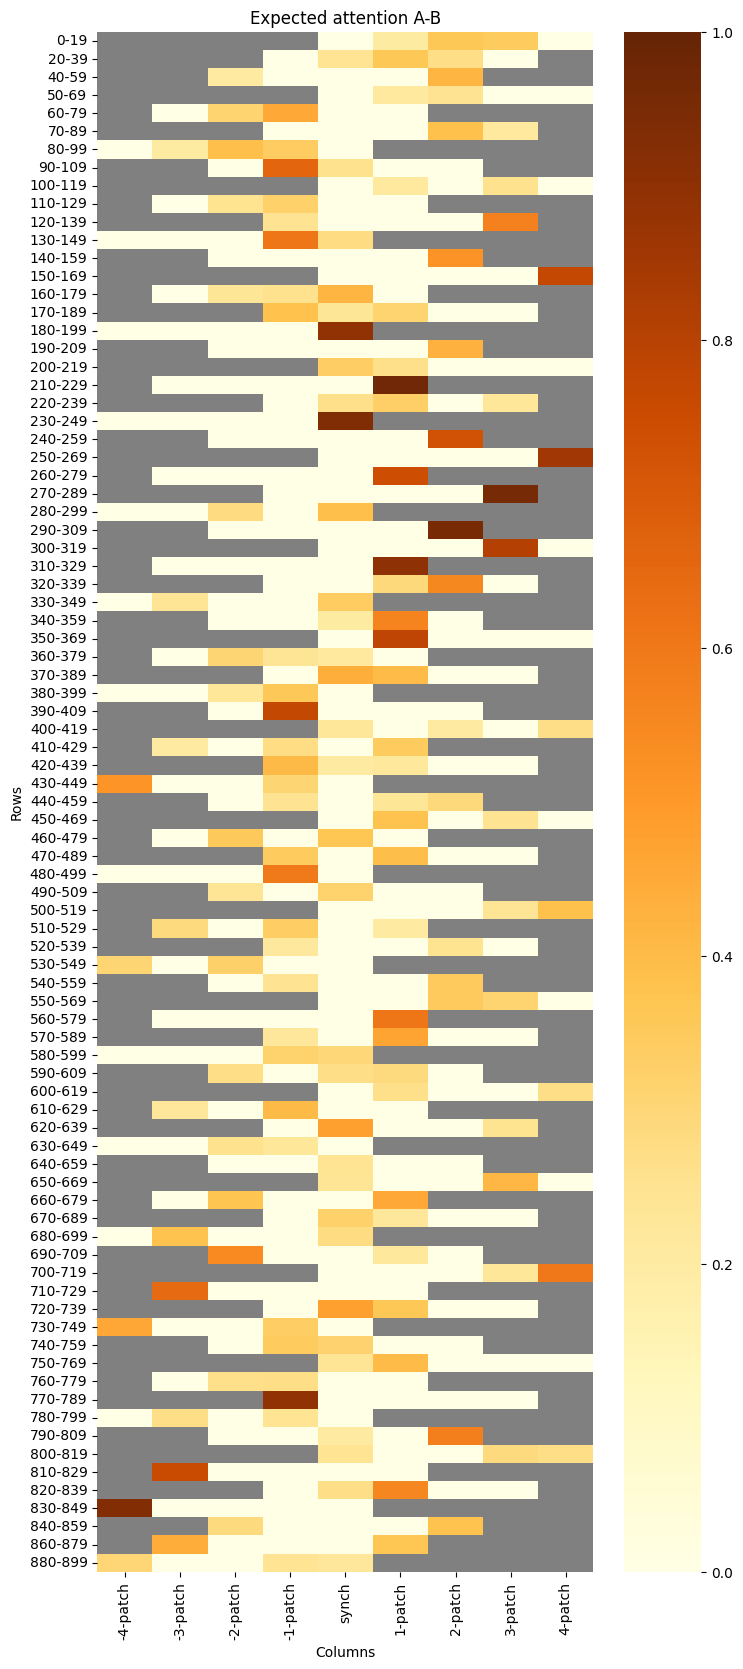

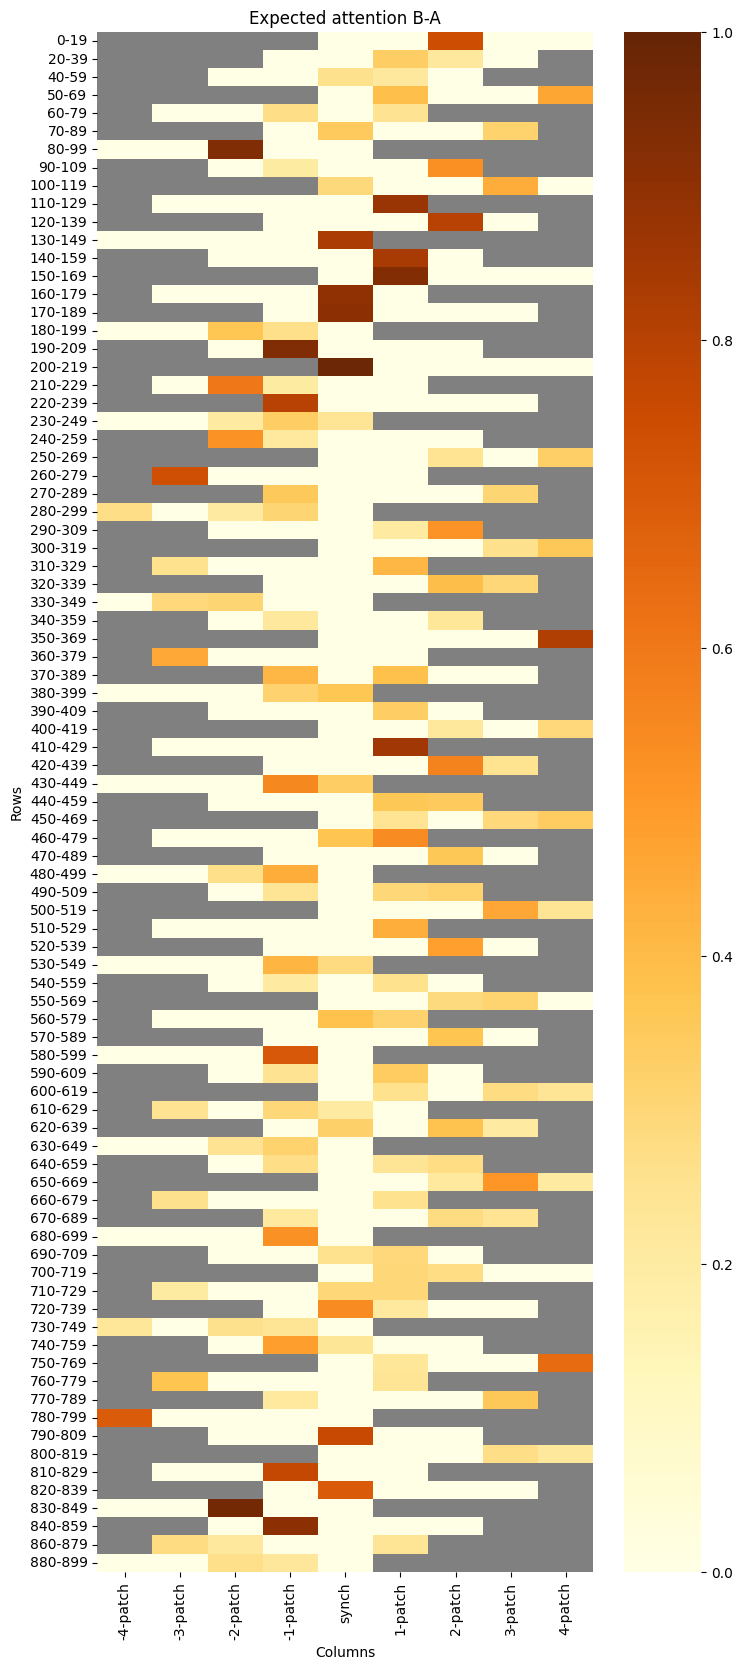

(         -4-patch  -3-patch  -2-patch  -1-patch     synch   1-patch   2-patch  \
 0-19          NaN       NaN       NaN       NaN  0.000000  0.202309  0.363196   
 20-39         NaN       NaN       NaN  0.000000  0.244409  0.361981  0.267448   
 40-59         NaN       NaN  0.204851  0.000000  0.000000  0.000000  0.420662   
 50-69         NaN       NaN       NaN       NaN  0.000000  0.211700  0.246134   
 60-79         NaN  0.000000  0.308713  0.454974  0.000000  0.000000       NaN   
 ...           ...       ...       ...       ...       ...       ...       ...   
 820-839       NaN       NaN       NaN  0.000000  0.273194  0.556979  0.000000   
 830-849  0.926078  0.000000  0.000000  0.000000  0.000000       NaN       NaN   
 840-859       NaN       NaN  0.287779  0.000000  0.000000  0.000000  0.375607   
 860-879       NaN  0.445283  0.000000  0.000000  0.000000  0.366835       NaN   
 880-899  0.301258  0.000000  0.000000  0.244744  0.222842       NaN       NaN   
 
           3-p

In [31]:
heatmap(a_b_dic_ordered,b_a_dic_ordered,final_list_order,"Expected attention A-B","Expected attention B-A")

In [32]:
a_b_dic_ordered

{'0-99': {'0-19': {'synch': 'ignore',
   '1-patch': 0.20230928,
   '2-patch': 0.36319616,
   '3-patch': 0.34660113,
   '4-patch': 'ignore',
   '-4-patch': -inf,
   '-3-patch': -inf,
   '-2-patch': -inf,
   '-1-patch': -inf},
  '20-39': {'-1-patch': 'ignore',
   'synch': 0.24440882,
   '1-patch': 0.36198103,
   '2-patch': 0.26744774,
   '3-patch': 'ignore',
   '-4-patch': -inf,
   '-3-patch': -inf,
   '-2-patch': -inf,
   '4-patch': -inf},
  '40-59': {'-2-patch': 0.20485123,
   '-1-patch': 'ignore',
   'synch': 'ignore',
   '1-patch': 'ignore',
   '2-patch': 0.42066193,
   '-4-patch': -inf,
   '-3-patch': -inf,
   '3-patch': -inf,
   '4-patch': -inf},
  '60-79': {'-3-patch': 'ignore',
   '-2-patch': 0.30871254,
   '-1-patch': 0.45497426,
   'synch': 'ignore',
   '1-patch': 'ignore',
   '-4-patch': -inf,
   '2-patch': -inf,
   '3-patch': -inf,
   '4-patch': -inf},
  '80-99': {'-4-patch': 'ignore',
   '-3-patch': 0.20117393,
   '-2-patch': 0.38694856,
   '-1-patch': 0.34049508,
   'synch'

# Store for all layers

In [33]:
def main():
    for i in range(len(tsa_layer_weights)):
        a_b_dic,b_a_dic_ = create_attn_dicts(par_index=i,Num_head=1,THRESHOLD=0.3)
        sums_counts_a,final_list_a, averages_a,sums_counts_b,final_list_b, averages_b  = calc_expected_attn(a_b_dic,b_a_dic_,f'heatmap_{i}_a',f'heatmap_{i}_b')
        
        df_a,df_b = heatmap(a_b_dic,b_a_dic_,final_list_order,f'heatmap_{i}_a',f'heatmap_b_{i}')
        df_a.to_csv(f'attn_dfs_test/dfs/heatmap_{i}_a.csv', index=False)
        df_b.to_csv(f'attn_dfs_test/dfs/heatmap_{i}_b.csv', index=False)
    
        
        
    

In [34]:
#main()


